## Inference

In [15]:
%matplotlib inline  
%load_ext autoreload
%autoreload 2

from sim.netrual import Component, NLT_reserve, NLT_components, NLT_accounts  # noqa
from sim.data import get_batch_price, get_price, read_csv
import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Prepare market Data

In [36]:
target = ['EOS', 'OMG', 'BNB','ARK', 'VEN', 'BAT']
market_prices = get_batch_price(target)
m = market_prices
pd.to_datetime(m['timestamp'], unit='s').describe()

count                   14028
unique                  14000
top       2017-09-29 18:35:00
freq                        2
first     2017-08-17 04:00:00
last      2017-10-05 01:35:00
Name: timestamp, dtype: object

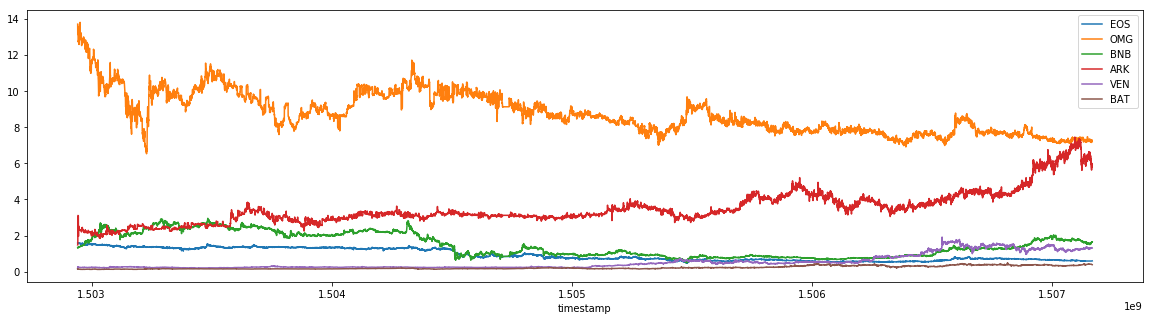

In [37]:
m.plot(x='timestamp', figsize=(20, 5))

## Denotes:

\begin{gather*}
\mathbb{P} : Price\\
\\action_{t}: Any\ actions\ that\ happened\ on\ time\ scale\ t.
\end{gather*}

### Inference

* Step 0: Create Components

In [41]:
tokens = [t for t in market_prices.columns if t != 'timestamp']
[Component(t) for t in tokens] 

[0.0 EOS => 0 NTL,
 0.0 OMG => 0 NTL,
 0.0 BNB => 0 NTL,
 0.0 ARK => 0 NTL,
 0.0 VEN => 0 NTL,
 0.0 BAT => 0 NTL]

* Step I: Warmup With inital auction

\begin{gather*}
\mathbb{P}_{auction_t} = \frac{\mathbb{P}_{target}}{\mathbb{P}_{market}} \times 1000 \\
t = Time_{current} - Time_{window}
\end{gather*}


In [53]:
def rational_warmup(timestamp, market_price, sender, inital_price):
    for c in NLT_components.values():
        res = c(timestamp).auction(sender, (float(inital_price) / float(market_price[c.token])) * 1000)
        print(res)

The market parice on $Round_0$ is :

In [54]:
mp = m.T[0].drop('timestamp')

In [55]:
start_time = m.T[0]['timestamp'] - Component.auction_window - 1
sender = 'satoshi'
inital_price = float(15)  # 15 USD

In [56]:
sender = 'satoshi'
inital_price = float(15)  # 15 USD

* before


In [57]:
NLT_components

{'ARK': 10099.717881213852 ARK => 6000 NTL,
 'BAT': 94217.14035904269 BAT => 6000 NTL,
 'BNB': 11212.159558816793 BNB => 6000 NTL,
 'EOS': 9475.43720630606 EOS => 6000 NTL,
 'OMG': 1095.2577900593658 OMG => 6000 NTL,
 'VEN': 90609.58504434436 VEN => 6000 NTL}

* after

In [47]:
rational_warmup(start_time, mp, sender, inital_price)

True
True
True
True
True
True


### Back to now

In [49]:
[c(m.T[0].timestamp) for c in NLT_components.values()]


[9475.43720630606 EOS => 6000 NTL,
 1095.2577900593658 OMG => 6000 NTL,
 11212.159558816793 BNB => 6000 NTL,
 10099.717881213852 ARK => 6000 NTL,
 90609.58504434436 VEN => 6000 NTL,
 94217.14035904269 BAT => 6000 NTL]

### Check the Price

### Price via highest components $P_h$.

\begin{gather*}
\frac{Highest(Price_{components}) \times min_{bid}(Highest(Price_{components}))}{1000} \ for\ each\ components
\end{gather*}

### Price via average auction bid $P_a$.

\begin{gather*}
\frac{\sum{component_{highest\ bid}\times component_{price}}}{NLT_{amount\ per\ round}}
\end{gather*}



In [59]:
from sim.utils import nlt_price as p_h,  nlt_fm_price as p_a

In [60]:
p_h(m.T[0]) # p_h

15.000000000000002

In [63]:
p_a(m.T[0].drop('timestamp')) # p_a

15.0

### $Round_1$ Get worth to redeeming and auction (Should be None)

In [64]:
from sim.utils import get_worth_to_auction, get_worth_to_redeem

In [65]:
get_worth_to_auction(m.T[0].drop('timestamp'), p_a)

{}

In [66]:
get_worth_to_auction(m.T[0].drop('timestamp'), p_h)

{}

In [67]:
get_worth_to_redeem(m.T[0].drop('timestamp'), p_h)

{}

In [68]:
get_worth_to_redeem(m.T[0].drop('timestamp'), p_a)

{}

### $Round_2$ Get worth to redeeming and auction

In [69]:
m.T[1].drop('timestamp')

EOS     1.570162
OMG    13.124210
BNB     1.315363
ARK     1.485190
VEN     0.278916
BAT     0.162557
Name: 1, dtype: float64

In [70]:
get_worth_to_auction(m.T[1].drop('timestamp'), p_a)

{'ARK': {'delta': 1598.0887288338272,
  'min_bid': 10099.717881213852,
  'price': 1.48519},
 'BAT': {'delta': 1282.414200060848,
  'min_bid': 94217.14035904269,
  'price': 0.16255720000000004},
 'BNB': {'delta': 1850.028222340321,
  'min_bid': 11212.159558816793,
  'price': 1.31536306},
 'EOS': {'delta': 1720.1172941058921,
  'min_bid': 9475.43720630606,
  'price': 1.5701619999999998},
 'OMG': {'delta': 2223.6950498556835,
  'min_bid': 1095.2577900593658,
  'price': 13.124210399999999}}

In [71]:
get_worth_to_auction(m.T[1].drop('timestamp'), p_h)

{'ARK': {'delta': 10272.432224030399,
  'min_bid': 10099.717881213852,
  'price': 1.48519},
 'BAT': {'delta': 9956.75769525742,
  'min_bid': 94217.14035904269,
  'price': 0.16255720000000004},
 'BNB': {'delta': 10524.371717536893,
  'min_bid': 11212.159558816793,
  'price': 1.31536306},
 'EOS': {'delta': 10394.460789302464,
  'min_bid': 9475.43720630606,
  'price': 1.5701619999999998},
 'OMG': {'delta': 10898.038545052255,
  'min_bid': 1095.2577900593658,
  'price': 13.124210399999999}}

In [72]:
get_worth_to_redeem(m.T[1].drop('timestamp'), p_a)

{'VEN': {'delta': 8674.343495196572,
  'min_bid': 90609.58504434436,
  'price': 0.2789156601}}

In [24]:
get_worth_to_redeem(m.T[1].drop('timestamp'), p_h)

{}

### $Round_2$ Get quantity for redeeming and auction

\begin{gather*}
auction_{quantity}=Component_{minbid}\times \frac{V_component}{V_ntl}\\
redeeming_{quantity}=\sum^{P_{redeem}<P_{component}} 1000
\end{gather*}



In [73]:
from sim.utils import determin_auction_quantity, determin_redeem_quantity



In [76]:
determin_auction_quantity(m.T[1].drop('timestamp'), p_a)

{'ARK': 11175.734235238473,
 'BAT': 102106.14312275201,
 'BNB': 12618.636811067074,
 'EOS': 10570.940278031076,
 'OMG': 1264.6923679944837}

In [28]:
determin_redeem_quantity(m.T[1].drop('timestamp'), p_h)

{}

In [29]:
determin_redeem_quantity(m.T[1].drop('timestamp'), p_a)

{}

### Stategey with $P_a$

In [30]:
plan_to_redeem = determin_redeem_quantity(m.T[1].drop('timestamp'), p_a)
plan_to_redeem

{}

In [31]:
plan_to_auction = determin_auction_quantity(m.T[1].drop('timestamp'), p_a)
plan_to_auction

{}

In [32]:
NLT_accounts

{'satoshi': 7000}

In [33]:
NLT_components['EOS'].minted

{0: {'bid': 1576.685553246836, 'sender': 'satoshi'}}

#### Redeem ARK



In [34]:
p_a(m.T[0]) # p_a

15.0

In [35]:
get_worth_to_redeem(m.T[1].drop('timestamp'), p_a)

{}

In [36]:
from sim.utils import redeem_strategy as redeem, auction_strategy as auction

In [37]:
redeem(plan_to_redeem, 'satoshi', m.T[1].timestamp)

{}

In [38]:
auction(plan_to_auction, 'satoshi', m.T[1].timestamp)

{}

### $Round_3$

In [39]:
NLT_reserve

{'ARK': 13393.423350086348,
 'ELF': 20528.45214171002,
 'EOS': 11576.685553246836,
 'INS': 15398.104347696219,
 'IOST': 375807.70951941406,
 'MANA': 158215.1926501074,
 'OMG': 11227.449703202661}

In [40]:
[t.min_bid for t in NLT_components.values()]

[1576.685553246836,
 1227.4497032026618,
 10528.452141710017,
 5398.1043476962195,
 148215.1926501074,
 365807.70951941406,
 3393.423350086348]

In [41]:
m.T[2].drop('timestamp')

EOS      9.503056
OMG     12.242008
ELF      1.422520
INS      2.715798
MANA     0.098882
IOST     0.040767
ARK      4.403600
Name: 2, dtype: float64

In [42]:
p_a(m.T[2]) # p_a

14.879862390431102

In [43]:
get_worth_to_auction(m.T[1].drop('timestamp'), p_a)

{}

In [44]:
get_worth_to_redeem(m.T[1].drop('timestamp'), p_a)

{}

In [45]:
plan_to_redeem = determin_redeem_quantity(m.T[2].drop('timestamp'), p_a)
plan_to_redeem

{}

In [46]:
plan_to_auction = determin_auction_quantity(m.T[2].drop('timestamp'), p_a)
plan_to_auction

{}

In [47]:
redeem(plan_to_redeem, 'satoshi', m.T[2].timestamp)

{}

In [48]:
auction(plan_to_auction, 'satoshi', m.T[2].timestamp)

{}